### Measuring Entity Susceptibility Scores in Movie Reviews with Conditional MI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
from itertools import product
import pandas as pd
import seaborn as sns
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
import numpy as np
import math
import statsmodels.api as sm
from measuring.estimate_probs import (
    estimate_prob_y_given_context_and_entity, 
    estimate_prob_x_given_e, 
    estimate_prob_next_word_given_x_and_entity, 
    estimate_cmi, score_model_for_next_word_prob, 
    create_position_ids_from_input_ids, 
    sharded_score_model,
    estimate_entity_score,
    kl_div,
    difference,
    difference_p_good_only,
    difference_abs_val,
)


In [3]:
LOAD_IN_8BIT = True

COMPUTE_CMI = True
COMPUTE_KL = True
COMPUTE_GOOD_BAD = True
COMPUTE_GOOD_BAD_ABS = True
COMPUTE_GOOD_BAD_P_GOOD_ONLY = True

In [4]:
with open('toy_movie_reviews.yaml', 'r') as file:
    review_adjs = yaml.safe_load(file)

In [5]:
pos_adjs_train = review_adjs["positive_adjectives_train"]
neg_adjs_train = review_adjs["negative_adjectives_train"]

pos_verbs = review_adjs["positive_verbs"]
neg_verbs = review_adjs["negative_verbs"]

In [6]:
movies = pd.read_csv("movies_metadata.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv
movies = movies[["title", "vote_count", "popularity"]].dropna().sort_values(by="vote_count")
movies["popularity"] = movies["popularity"].astype(float)
movies_sample = pd.concat([movies.iloc[:250], movies.iloc[-250:]], axis=0)
# movies_sample = pd.concat([movies.iloc[-250:]], axis=0)

/scratch/tmp.38771879.kevidu/ipykernel_57977/527075013.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv


In [7]:
movies_sample

,title,vote_count,popularity
45465,Queerama,0.0,0.163015
23680,Brothers,0.0,0.007073
23677,Willie and Phil,0.0,0.326500
23674,Luther,0.0,1.170857
23671,Brother Rat,0.0,0.174691
...,...,...,...
26564,Deadpool,11444.0,187.860492
17818,The Avengers,12000.0,89.887648
14551,Avatar,12114.0,185.070892
12481,The Dark Knight,12269.0,123.167259


<AxesSubplot:xlabel='vote_count', ylabel='popularity'>

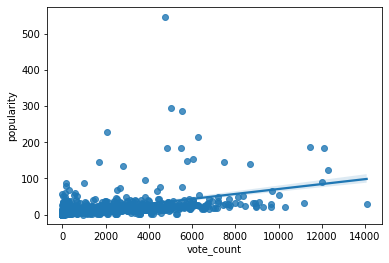

In [8]:
# WHETHER TO USE VOTE COUNT OR POPULARITY

# movies.sort_values(by="popularity").tail(50)
# movies.sort_values(by="vote_count").tail(50)
sns.regplot(data=movies, x="vote_count", y="popularity")

In [9]:
template = "Here's a review for the movie '{}': I thought this movie was {}, I {} it.\nConclusion: This movie is"
template.format(movies_sample["title"].iloc[0], pos_adjs_train[0], pos_verbs[0])
movies_sample["sentence"] = movies_sample["title"].apply(lambda title: template.format(title, pos_adjs_train[0], pos_verbs[0])) 


In [10]:
context_template = "Here's a movie review: 'The movie was {} and I {} it'. "
num_adjs = min(len(pos_adjs_train), len(neg_adjs_train))
num_verbs = min(len(pos_verbs), len(neg_verbs))

pos_contexts = [context_template.format(adj, verb) for (adj, verb) in product(pos_adjs_train[:num_adjs], pos_verbs[:num_verbs])]
neg_contexts = [context_template.format(adj, verb) for (adj, verb) in product(neg_adjs_train[:num_adjs], neg_verbs[:num_verbs])]
contexts = neg_contexts
# contexts = pos_contexts + neg_contexts

print("Number of positive contexts: ", len(pos_contexts))
print("Number of negative contexts: ", len(neg_contexts))
print(contexts[::10])

Number of positive contexts:  72
Number of negative contexts:  72
["Here's a movie review: 'The movie was dreadful and I hated it'. ", "Here's a movie review: 'The movie was depressing and I disliked it'. ", "Here's a movie review: 'The movie was nasty and I despised it'. ", "Here's a movie review: 'The movie was ugly and I hated it'. ", "Here's a movie review: 'The movie was annoying and I disliked it'. ", "Here's a movie review: 'The movie was frustrating and I despised it'. ", "Here's a movie review: 'The movie was unpleasant and I hated it'. ", "Here's a movie review: 'The movie was awful and I disliked it'. "]


In [11]:
def format_query(query, entity, context, prefix=""):
    return prefix + context + query.format(entity)

In [12]:
# from functools import partial
# def fill_in_template(template: str, title: str, adj: str, verb: str):
#     return template.format(title, adj, verb)

# pos_template_partial = partial(fill_in_template, template=template, verb=pos_verbs[0])
# neg_template_partial = partial(fill_in_template, template=template, verb=neg_verbs[0])

# for adj in pos_adjs_train:
#     movies_sample[f"pos_{adj}_context"] = movies_sample["title"].apply(lambda title: pos_template_partial(title=title, adj=adj))

# for adj in neg_adjs_train:
#     movies_sample[f"neg_{adj}_context"] = movies_sample["title"].apply(lambda title: neg_template_partial(title=title, adj=adj))

In [13]:
movies_sample.head()

,title,vote_count,popularity,sentence
45465,Queerama,0.0,0.163015,Here's a review for the movie 'Queerama': I th...
23680,Brothers,0.0,0.007073,Here's a review for the movie 'Brothers': I th...
23677,Willie and Phil,0.0,0.326500,Here's a review for the movie 'Willie and Phil...
23674,Luther,0.0,1.170857,Here's a review for the movie 'Luther': I thou...
23671,Brother Rat,0.0,0.174691,Here's a review for the movie 'Brother Rat': I...


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "EleutherAI/pythia-70m-deduped"

try:
    model = GPTNeoXForCausalLM.from_pretrained(
      model_name,
      load_in_8bit=LOAD_IN_8BIT,
      device_map="auto"
    )
except:
    model = GPTNeoXForCausalLM.from_pretrained(
      model_name,
      load_in_8bit=False,
    ).to(device)

tokenizer = AutoTokenizer.from_pretrained(
  model_name,
  padding_side="left",
)

query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
inputs = tokenizer(format_query(query=query, entity=movies_sample.iloc[0]["title"], context=contexts[0]), return_tensors="pt").to(device)
# inputs = tokenizer(movies_sample.iloc[0]["sentence"], return_tensors="pt").to(device)
tokens = model.generate(**inputs)
probs, top_tokens = torch.topk(torch.nn.functional.softmax(model(**inputs).logits[0, -1]), k=10)
print(sum(probs))
tokenizer.decode(top_tokens)
# print(tokens)
# tokenizer.decode(tokens[0])


False

===================================BUG REPORT===================================
The following directories listed in your path were found to be non-existent: {PosixPath('1')}
The following directories listed in your path were found to be non-existent: {PosixPath('StdEnv'), PosixPath('gcc/4.8.5')}
The following directories listed in your path were found to be non-existent: {PosixPath('1')}
The following directories listed in your path were found to be non-existent: {PosixPath('1')}
The following directories listed in your path were found to be non-existent: {PosixPath('//0.0.0.0'), PosixPath('https'), PosixPath('0/user/kevidu')}
The following directories listed in your path were found to be non-existent: {PosixPath('1;nccl/2.11.4-1'), PosixPath('1;julia/1.8.5'), PosixPath('1;hdf5/1.10.1'), PosixPath('1;openblas/0.3.15'), PosixPath('1;cuda/11.3.1'), PosixPath('1;cudnn/8.2.1.32'), PosixPath('1;r/4.2.2'), PosixPath('1;gcc/8.2.0'), PosixPath('1;eth_proxy'), PosixPath('StdEnv'), Posix

/cluster/home/kevidu/.local/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: /cluster/work/cotterell/kdu/miniforge3 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/cluster/apps/gcc-8.2.0/cuda-11.3.1-o54iuxgz6jm4csvkstuj5hjg4tvd44h3/lib64/libcudart.so.11.0'), PosixPath('/cluster/apps/gcc-8.2.0/cuda-11.3.1-o54iuxgz6jm4csvkstuj5hjg4tvd44h3/lib64/libcudart.so')}.. We select the PyTorch default libcudart.so, which is {torch.version.cuda},but this might missmatch with the CUDA version that is

tensor(0.6411, device='cuda:0', grad_fn=<AddBackward0>)


/scratch/tmp.38771879.kevidu/ipykernel_57977/544325201.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs, top_tokens = torch.topk(torch.nn.functional.softmax(model(**inputs).logits[0, -1]), k=10)


'\nicky�icedumpire001002��'

In [15]:
answer_map = {
    0: ["0", "zero", "Zero"],
    1: ["1", "one", "One"],
    2: ["2", "two", "Two"],
    3: ["3", "three", "Three"],
    4: ["4", "four", "Four"],
    5: ["5", "five", "Five"],
}
answer_map_token_ids = {k: torch.tensor(tokenizer.convert_tokens_to_ids(v), device=model.device) for k, v in answer_map.items()}
answer_map_token_ids

{0: tensor([   17, 10528, 26561], device='cuda:0'),
 1: tensor([  18,  531, 4041], device='cuda:0'),
 2: tensor([  19, 9389, 7910], device='cuda:0'),
 3: tensor([   20, 13524, 11831], device='cuda:0'),
 4: tensor([   21, 12496, 14039], device='cuda:0'),
 5: tensor([   22, 12071, 25438], device='cuda:0')}

In [16]:
if COMPUTE_CMI:
    query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
    from tqdm import tqdm
    tqdm.pandas()
    movies_sample["susceptibility_score"] = movies_sample["title"].progress_apply(lambda e: estimate_cmi(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, answer_map=None))
    # movies_sample["susceptibility_score"] = movies_sample["title"].progress_apply(lambda e: estimate_cmi(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, answer_map=answer_map_token_ids))

  0%|          | 0/500 [00:00<?, ?it/s]Using pad_token, but it is not set yet.


Setting model.config.pad_token_id to model.config.eos_token_id


100%|██████████| 500/500 [02:34<00:00,  3.23it/s]


In [17]:
import transformers
print(transformers.__version__)

4.26.0.dev0


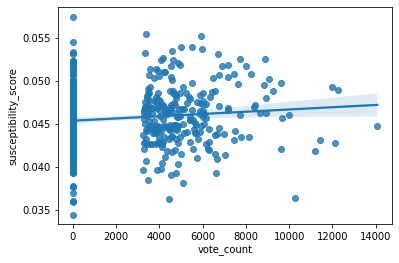

In [18]:
if COMPUTE_CMI:
    movies_sample.value_counts("susceptibility_score")
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score"]
    ols_model = sm.OLS(y, x).fit()
    ols_model.summary()

In [19]:
if COMPUTE_KL:
    query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
    from tqdm import tqdm
    tqdm.pandas()
    # movies_sample["susceptibility_score_kl"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=kl_div, answer_map=None))
    movies_sample["susceptibility_score_kl"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=kl_div, answer_map=answer_map_token_ids))


100%|██████████| 500/500 [00:21<00:00, 22.95it/s]


susceptibility_score_kl
-0.000463    2
-0.000569    1
 0.000136    1
 0.000132    1
 0.000132    1
            ..
-0.000105    1
-0.000105    1
-0.000107    1
-0.000108    1
 0.000590    1
Length: 499, dtype: int64
                               OLS Regression Results                              
Dep. Variable:     susceptibility_score_kl   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                 -0.001
Method:                      Least Squares   F-statistic:                    0.6242
Date:                     Tue, 05 Dec 2023   Prob (F-statistic):              0.430
Time:                             10:20:36   Log-Likelihood:                 3453.3
No. Observations:                      500   AIC:                            -6903.
Df Residuals:                          498   BIC:                            -6894.
Df Model:                                1                                         
Covariance Type:             

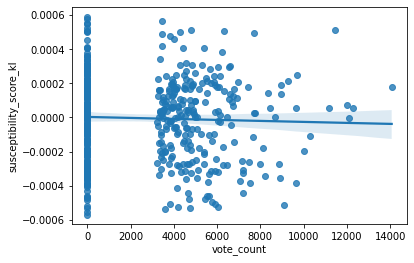

In [20]:
if COMPUTE_KL:
    print(movies_sample.value_counts("susceptibility_score_kl"))
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score_kl")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_kl"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())

In [21]:
answer_map_good_bad = {
    0: ["bad", "Bad"],
    1: ["good", "Good"],
}
answer_map_good_bad_token_ids = {
    k: torch.tensor(tokenizer.convert_tokens_to_ids(v), device=model.device) for k, v in answer_map_good_bad.items()
}

if COMPUTE_GOOD_BAD:
    query = "The quality of this movie, '{}', is rated "
    from tqdm import tqdm
    tqdm.pandas()
    movies_sample["susceptibility_score_good_bad"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=difference, answer_map=answer_map_good_bad_token_ids))


100%|██████████| 500/500 [00:20<00:00, 24.37it/s]


susceptibility_score_good_bad
-0.244624    6
-0.148088    3
-0.275020    3
-0.296175    2
-0.939941    2
            ..
-1.004881    1
-1.004881    1
-1.005550    1
-1.006218    1
 0.581773    1
Length: 452, dtype: int64
                                  OLS Regression Results                                 
Dep. Variable:     susceptibility_score_good_bad   R-squared:                       0.001
Model:                                       OLS   Adj. R-squared:                 -0.001
Method:                            Least Squares   F-statistic:                    0.7176
Date:                           Tue, 05 Dec 2023   Prob (F-statistic):              0.397
Time:                                   10:20:57   Log-Likelihood:                -236.70
No. Observations:                            500   AIC:                             477.4
Df Residuals:                                498   BIC:                             485.8
Df Model:                                      1           

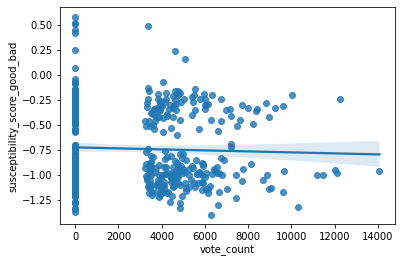

In [22]:
if COMPUTE_GOOD_BAD:
    print(movies_sample.value_counts("susceptibility_score_good_bad"))
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score_good_bad")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_good_bad"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())

100%|██████████| 500/500 [00:20<00:00, 24.48it/s]


susceptibility_score_good_bad_abs
0.244624    6
0.275020    3
0.925883    2
0.277026    2
0.513353    2
           ..
0.536514    1
0.528079    1
0.518307    1
0.508261    1
1.397713    1
Length: 453, dtype: int64
                                    OLS Regression Results                                   
Dep. Variable:     susceptibility_score_good_bad_abs   R-squared:                       0.000
Model:                                           OLS   Adj. R-squared:                 -0.002
Method:                                Least Squares   F-statistic:                    0.1195
Date:                               Tue, 05 Dec 2023   Prob (F-statistic):              0.730
Time:                                       10:21:17   Log-Likelihood:                -193.76
No. Observations:                                500   AIC:                             391.5
Df Residuals:                                    498   BIC:                             399.9
Df Model:                         

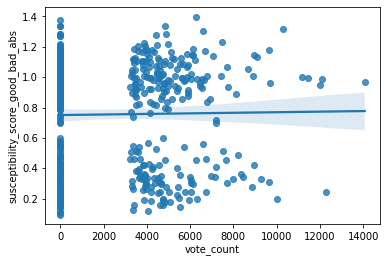

In [23]:
if COMPUTE_GOOD_BAD_ABS:
    query = "The quality of this movie, '{}', is rated "
    from tqdm import tqdm
    tqdm.pandas()
    movies_sample["susceptibility_score_good_bad_abs"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=difference_abs_val, answer_map=answer_map_good_bad_token_ids))

if COMPUTE_GOOD_BAD_ABS:
    print(movies_sample.value_counts("susceptibility_score_good_bad_abs"))
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score_good_bad_abs")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_good_bad_abs"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())

100%|██████████| 500/500 [00:21<00:00, 23.72it/s]


susceptibility_score_good_bad_p_good_only
-0.122312    5
-0.137510    3
-0.518307    3
-0.071567    3
-0.481285    2
            ..
-0.499963    1
-0.502441    1
-0.502441    1
-0.502775    1
 0.290887    1
Length: 461, dtype: int64
                                        OLS Regression Results                                       
Dep. Variable:     susceptibility_score_good_bad_p_good_only   R-squared:                       0.001
Model:                                                   OLS   Adj. R-squared:                 -0.001
Method:                                        Least Squares   F-statistic:                    0.7176
Date:                                       Tue, 05 Dec 2023   Prob (F-statistic):              0.397
Time:                                               10:21:40   Log-Likelihood:                 109.88
No. Observations:                                        500   AIC:                            -215.8
Df Residuals:                                        

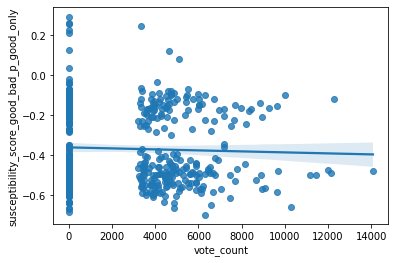

In [24]:
if COMPUTE_GOOD_BAD_P_GOOD_ONLY:
    query = "The quality of this movie, '{}', is rated "
    from tqdm import tqdm
    tqdm.pandas()
    movies_sample["susceptibility_score_good_bad_p_good_only"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=difference_p_good_only, answer_map=answer_map_good_bad_token_ids))

if COMPUTE_GOOD_BAD_P_GOOD_ONLY:
    print(movies_sample.value_counts("susceptibility_score_good_bad_p_good_only"))
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score_good_bad_p_good_only")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_good_bad_p_good_only"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())